<a href="https://colab.research.google.com/github/benbaz-2/comp551/blob/main/assignment2_102124.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
np.random.seed(42)

## Task 1: Linear Regression with non-basis functions

### 1. Data generation

In [2]:
# generate data
N = 80   # train size
T = 20   # test size

# generate data
f = lambda x: np.sin(np.sqrt(x)) + np.cos(x) + np.sin(x)

def generate_data(n):
  x = np.linspace(0, 20, n)
  x = np.sort(x)
  e = np.random.normal(0, 1, n)
  y = f(x) + e
  return x, y

x_train, y_train = generate_data(N)
x_test, y_test = generate_data(T)

# generate range for plotting
x_range = np.linspace(0, 20, 1000)

Text(0, 0.5, 'y')

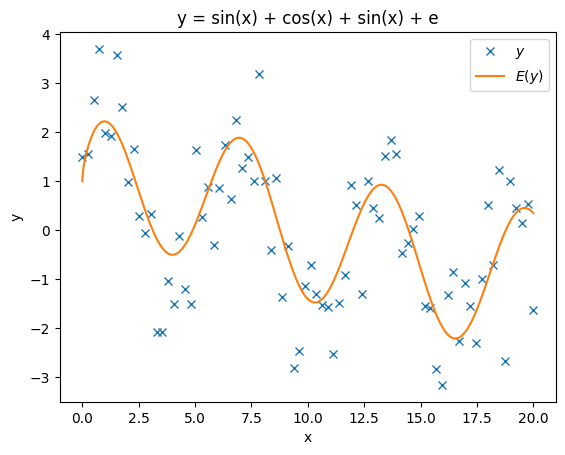

In [3]:
# plot data
plt.plot(x_train, y_train, 'x', label='$y$')
plt.plot(x_range, f(x_range), label='$E(y)$')
plt.legend()

plt.title('y = sin(x) + cos(x) + sin(x) + e')
plt.xlabel('x')
plt.ylabel('y')

### 2. Non-linear basis functions

Text(0.5, 0.98, 'Gaussian basis functions')

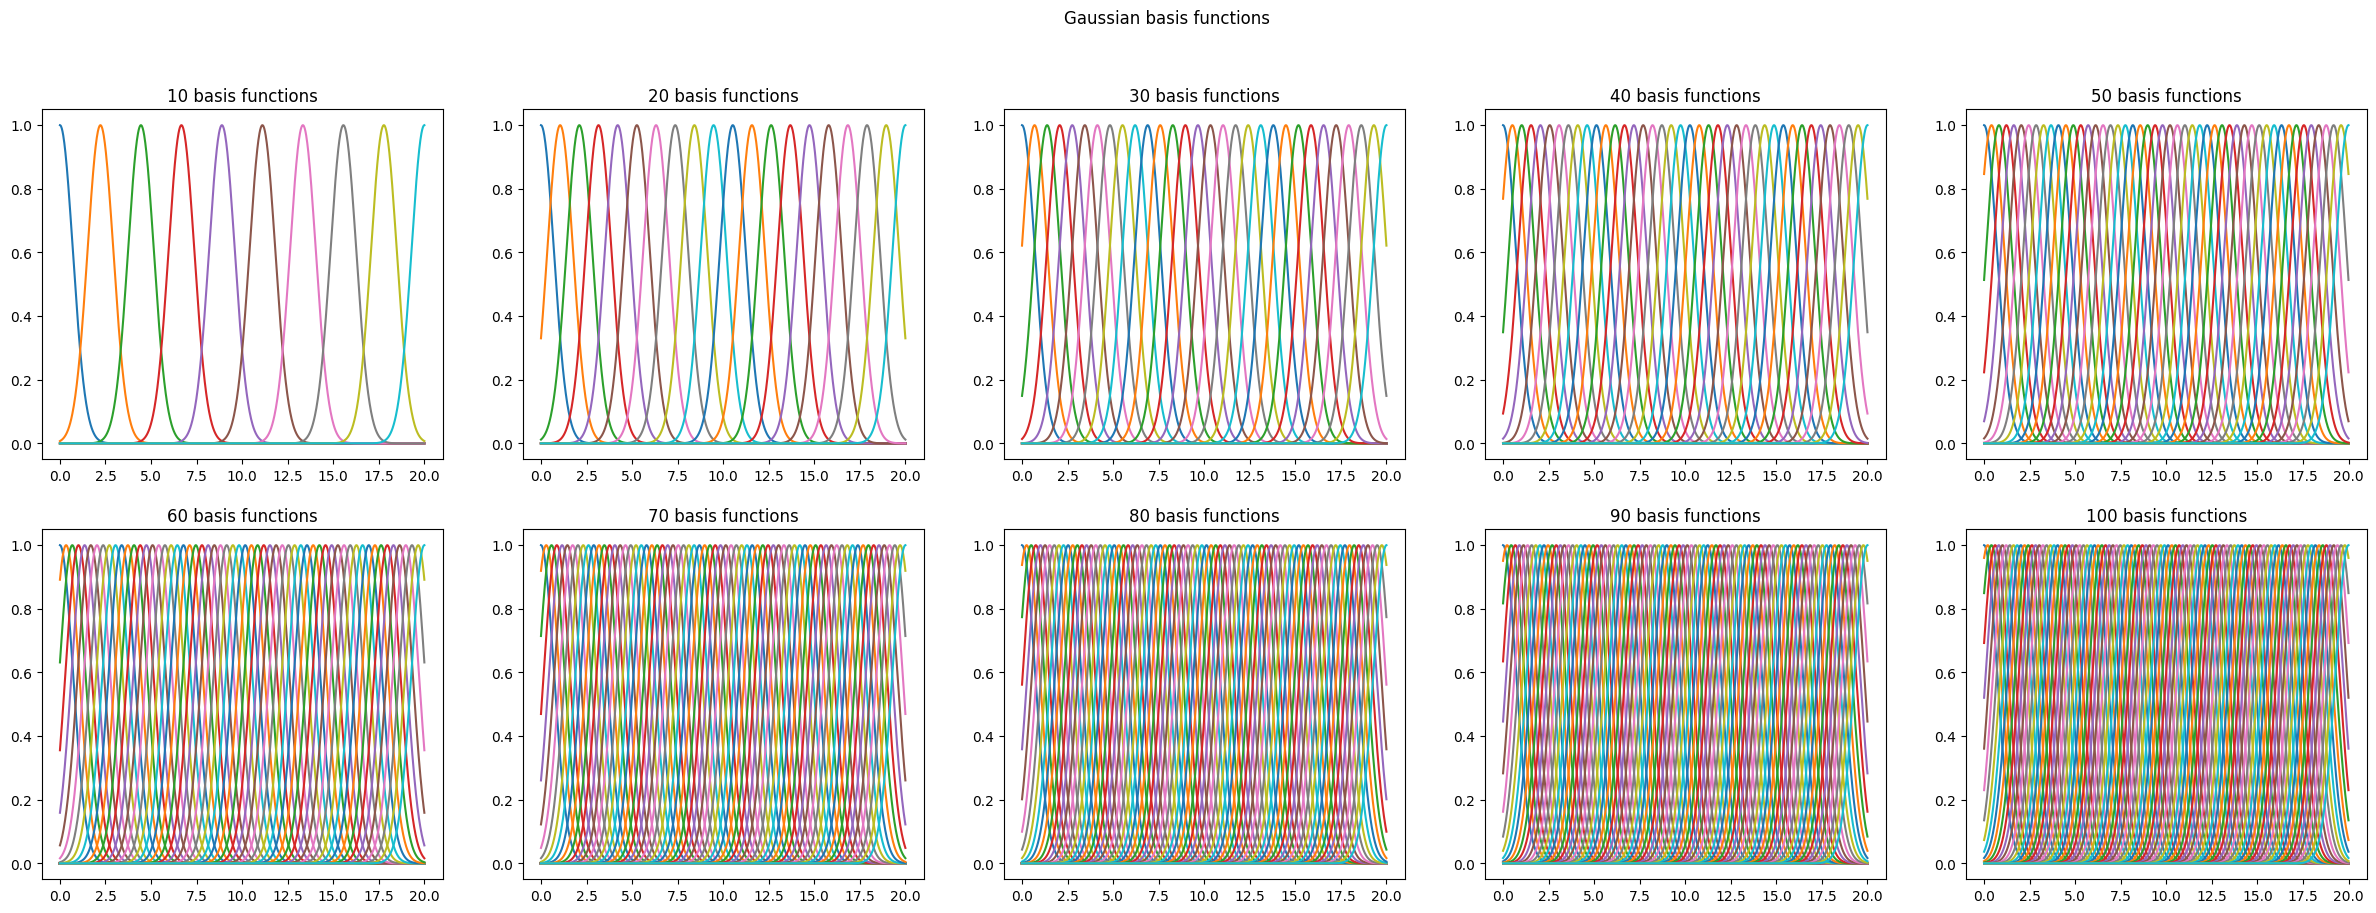

In [4]:
# plot gaussian basis functions
gaussian = lambda x, mu: np.exp(-(x-mu)**2)

fig, ax = plt.subplots(2, 5, figsize=(30, 10))
ax = ax.flatten()

num_bases = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for i, n in enumerate(num_bases[1:]):
  mus = np.linspace(0, 20, n)
  ax[i].set_title(f'{n} basis functions')
  for mu in mus:
    ax[i].plot(x_range, gaussian(x_range, mu))

fig.suptitle('Gaussian basis functions')

### 3. Model fitting

In [5]:
# Implementation of the gaussian regression model
class GaussianRegression:
  def __init__(self, D, add_bias=True):
    self.add_bias = add_bias
    self.d = D                                        # b is the number of gaussian bases used
    self.w = None

  # This method creates the design matrix X
  def gaussian_bases(self, x):
    X = np.ones((len(x), self.d))
    mus = np.linspace(0, 20, self.d)
    for i, mu in enumerate(mus):
      X[:, i] = gaussian(x, mu)
    return X

  def fit(self, x, y):
    X = self.gaussian_bases(x)                      # Generate the design matrix
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
    return self

  def predict(self, x):
    X = self.gaussian_bases(x)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ self.w

  def sse(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.sum((y - self.predict(x))**2)                       # Return the sum of squared error

  def mse(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.mean((y - self.predict(x))**2)

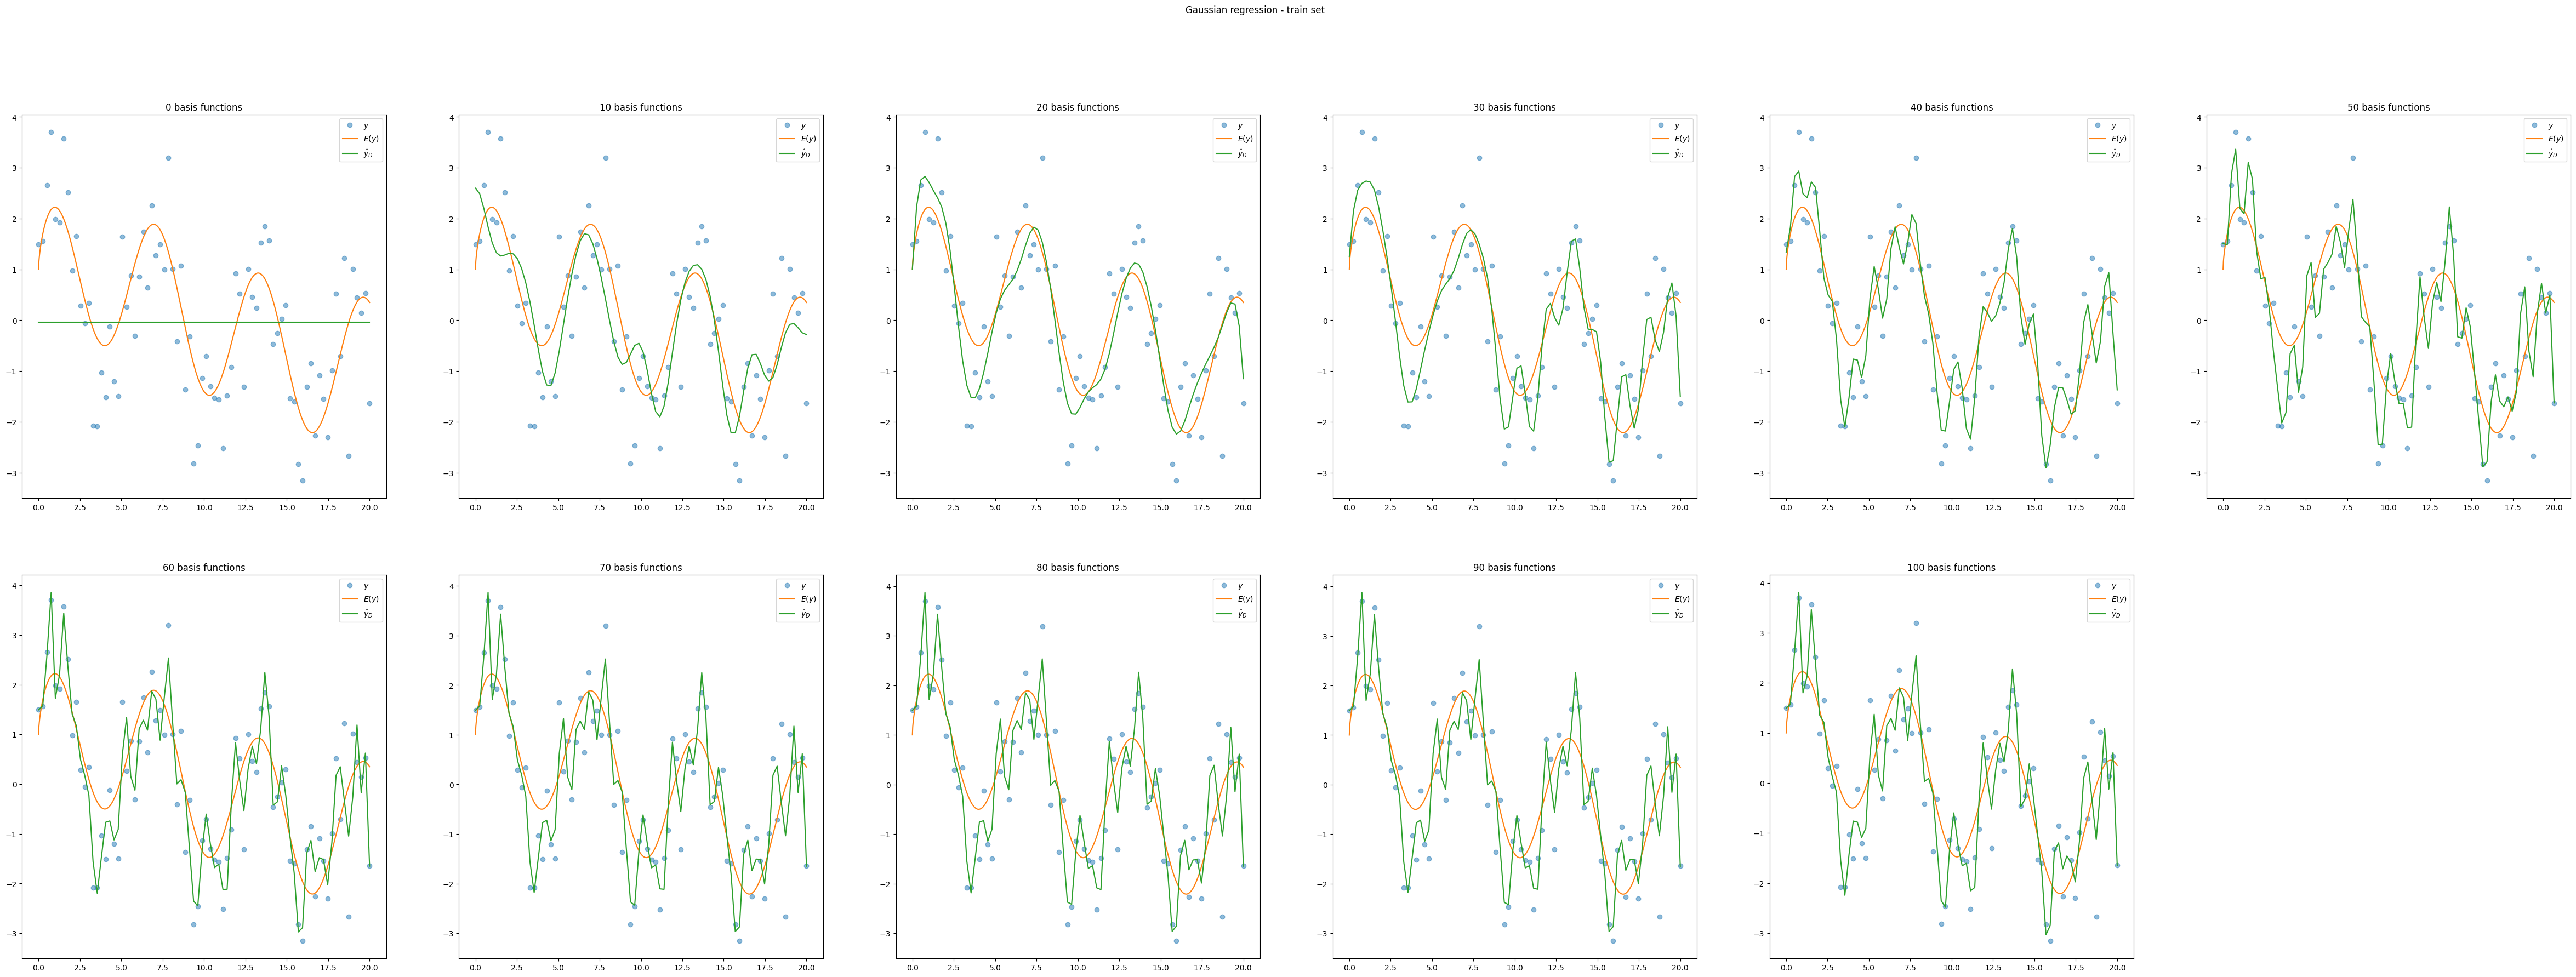

In [6]:
# plotting predictions on train set for models with different number of basis functions
fig, ax = plt.subplots(2, 6, figsize=(60, 20))
ax = ax.flatten()

for i, n in enumerate(num_bases):
  model = GaussianRegression(n)
  model.fit(x_train, y_train)
  yh = model.predict(x_train)

  ax[i].set_title(f'{n} basis functions')
  ax[i].plot(x_train, y_train, 'o', label='$y$', alpha=0.5)
  ax[i].plot(x_range, f(x_range), label='$E(y)$')
  ax[i].plot(x_train, yh, label='$\hat{y}_D$')
  ax[i].legend()

fig.suptitle('Gaussian regression - train set')

ax[11].set_visible(False)

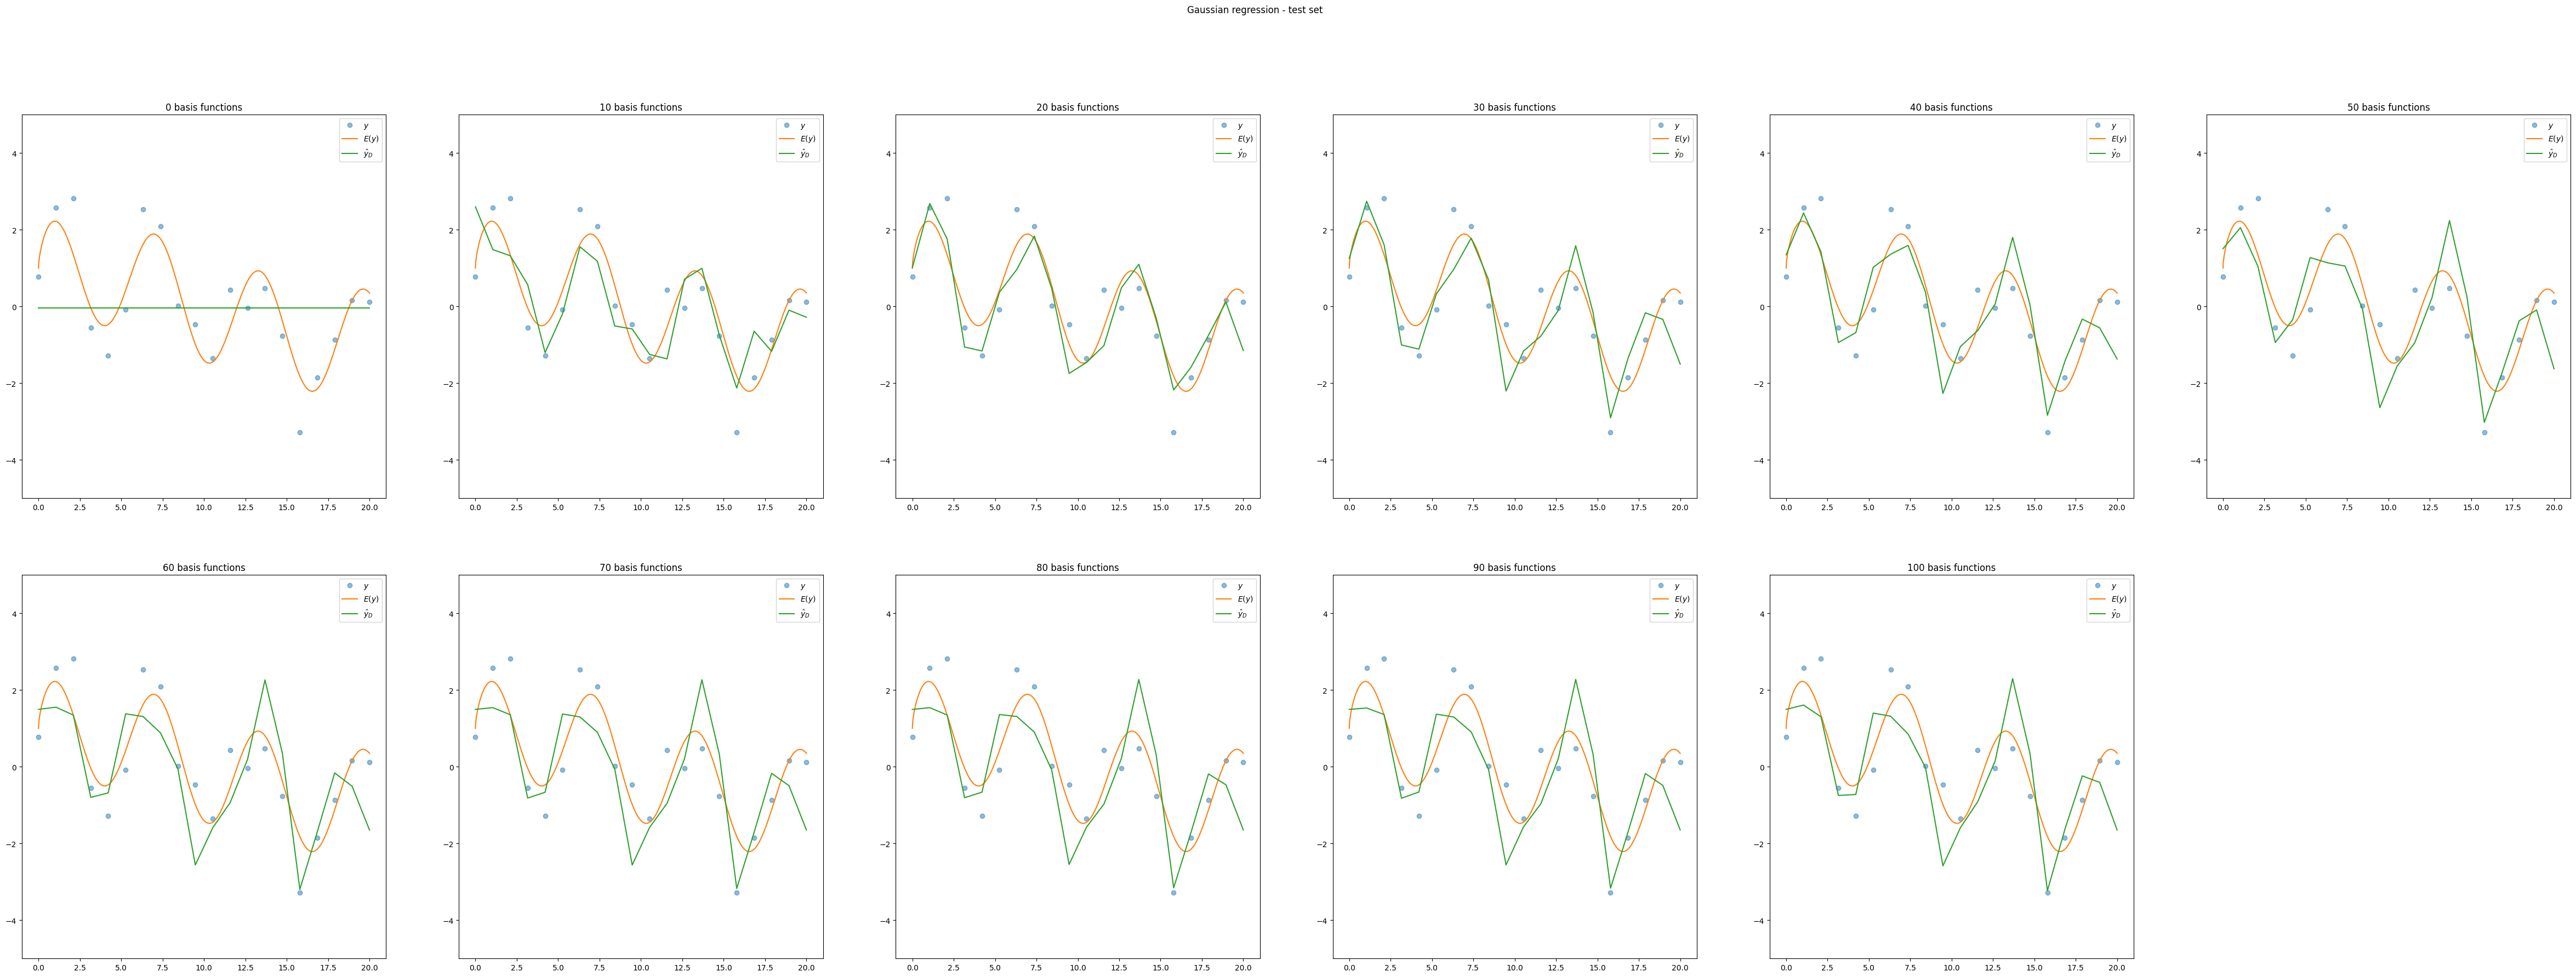

In [7]:
# plotting predictions on train set for models with different number of basis functions
fig, ax = plt.subplots(2, 6, figsize=(60, 20))
ax = ax.flatten()

for i, n in enumerate(num_bases):
  model = GaussianRegression(n)
  model.fit(x_train, y_train)
  yh = model.predict(x_test)

  ax[i].set_title(f'{n} basis functions')
  ax[i].plot(x_test, y_test, 'o', label='$y$', alpha=0.5)
  ax[i].plot(x_range, f(x_range), label='$E(y)$')
  ax[i].plot(x_test, yh, label='$\hat{y}_D$')
  ax[i].legend()
  ax[i].set_ylim(-5, 5)

fig.suptitle('Gaussian regression - test set')

ax[11].set_visible(False)

### 4. Model selection

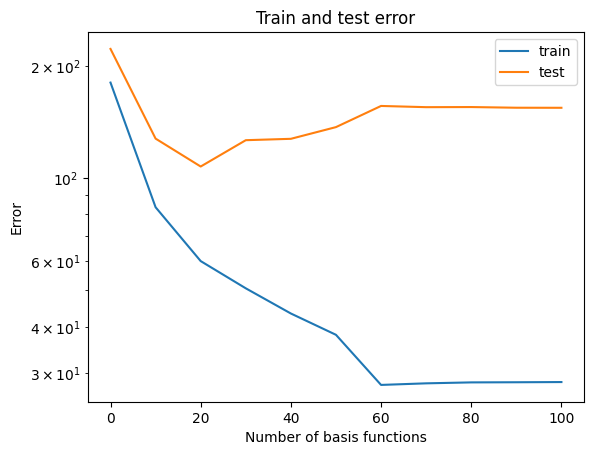

In [8]:
# calculating train and test error

# note, the error is way larger when sampling using np.random.uniform, rather than linspace

x_train, y_train = generate_data(N)
x_test, y_test = generate_data(N)

train_errors = np.zeros(len(num_bases))
test_errors = np.zeros(len(num_bases))

for i, n in enumerate(num_bases):
  model = GaussianRegression(n)
  model.fit(x_train, y_train)
  train_errors[i] = model.sse(x_train, y_train)
  test_errors[i] = model.sse(x_test, y_test)

plt.plot(num_bases, train_errors, label='train')
plt.plot(num_bases, test_errors, label='test')
plt.legend()
plt.title('Train and test error')
plt.xlabel('Number of basis functions')
plt.ylabel('Error')
plt.yscale('log')


### 5. Explanation

The optimal model seems to be the one with 20 basis functions, though 10 and 30 are very close and may have lower SSE with another random sample drawn from the same distribution.

As the number of basis functions increases, initially, the predictions start following the shape of the distribution then, they become more erratic as the model tries to fit the randomness of the data. As a consequence, we can see that while the SSE on the train set decreases slightly, the SSE on the test set increases drastically and the model looks different from the original distribution. The best model has enough power to fit the original distribution but not enough to start fitting the noise.

Interestingly, this effect is more pronouced when the x values of the training and test set are different (put figure), i.e. when using *np.random.uniform*, rather than *np.linspace*. Our hypothesis is that the model is constrained to give values close to the distribution on x values that it has already seen. As the power of the model increases, its variance increases and the x values between the training points have erratic predictions, sometimes very far from the distribution, causing very large test error.

## Task 2: Bias variance tradeoff with multiple fits

### 2. Plotting multiple fits

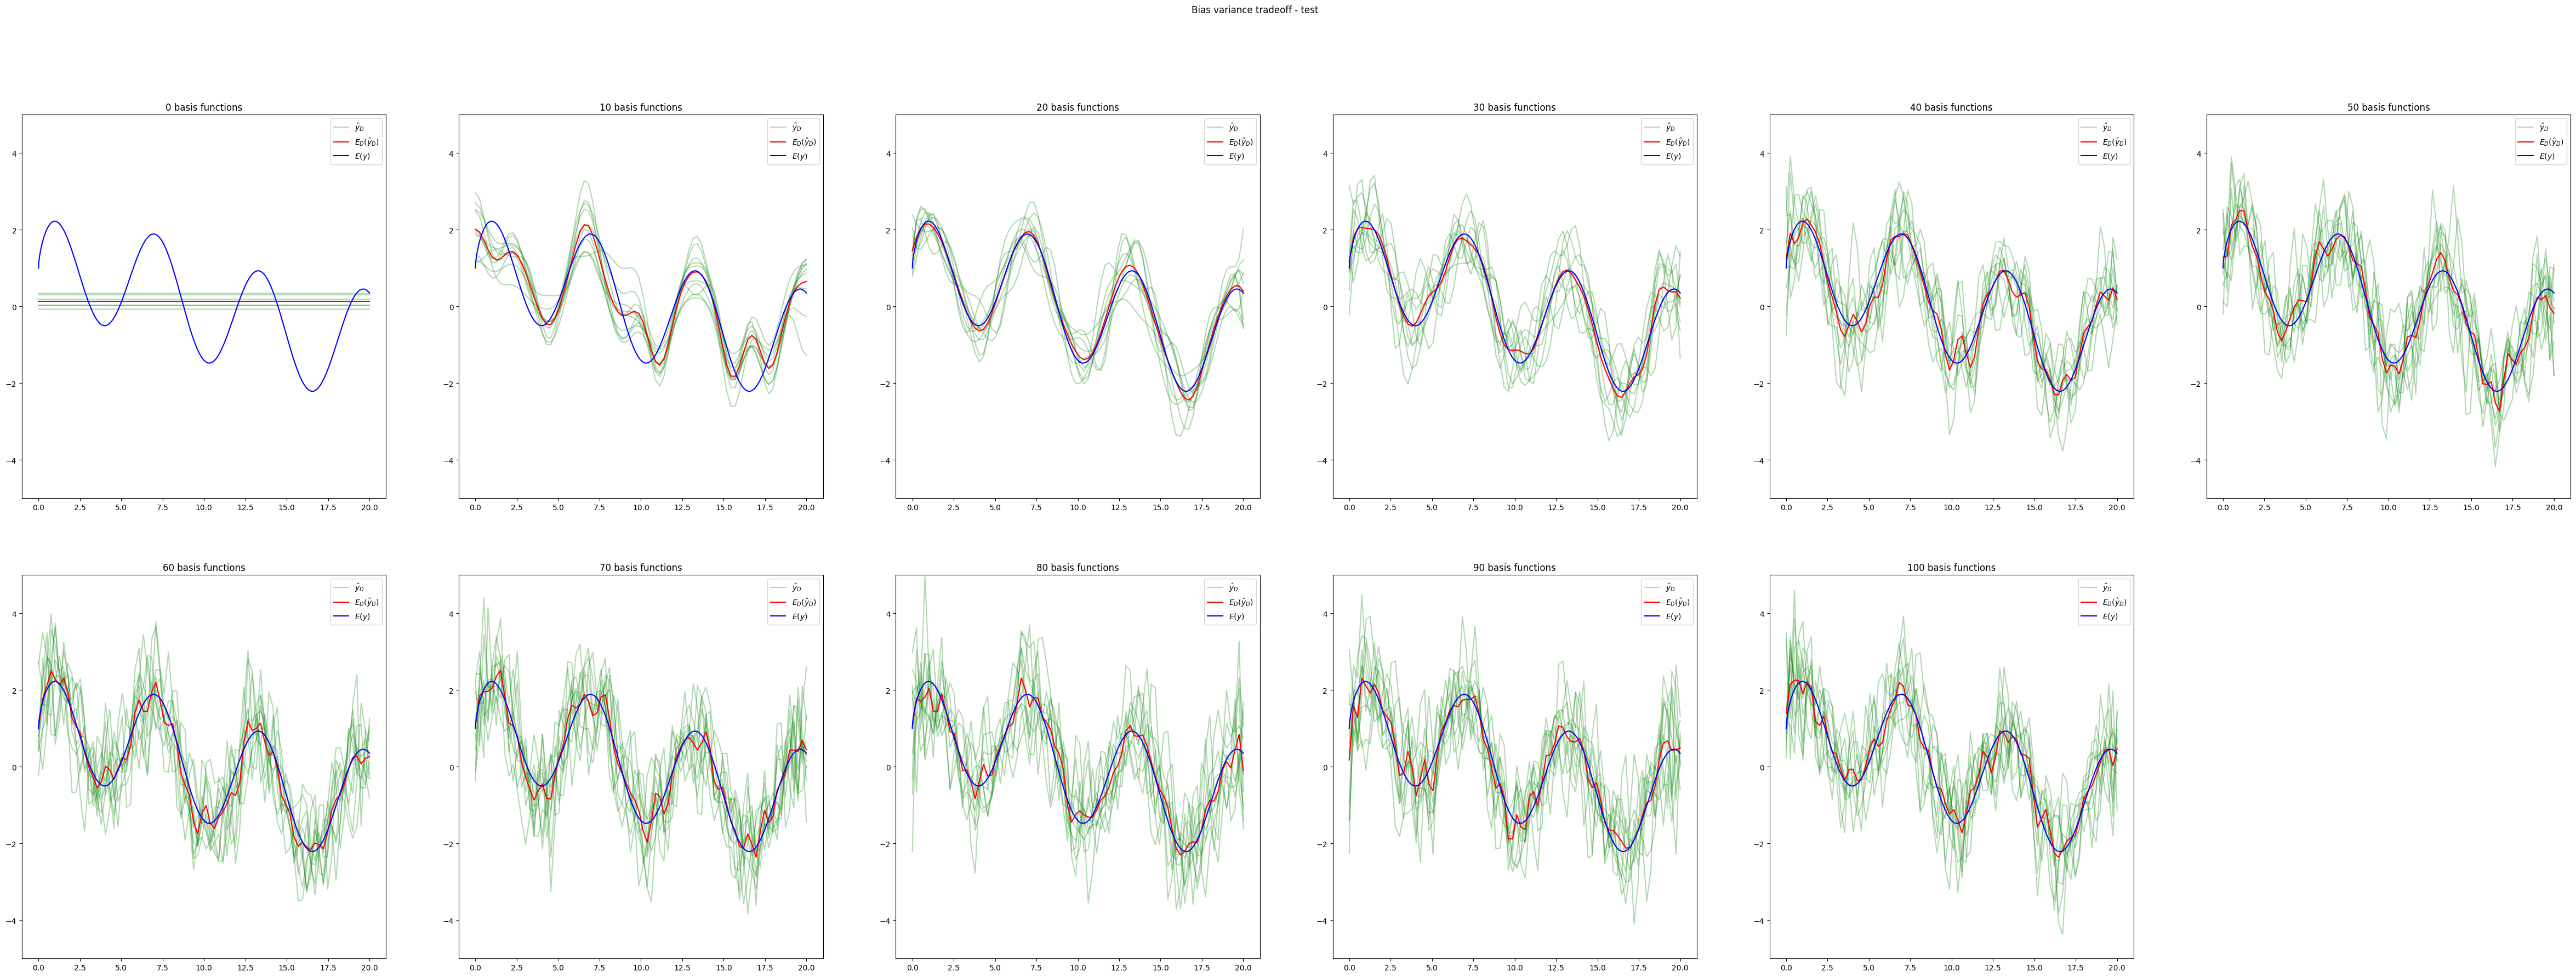

In [9]:
# bias variance tradeoff
# note, will use linspace for x_test to be able to graph the results

num_repetitions = 10

# range for plotting predictions on test values
x_test = np.linspace(0, 20, T)

# number of basis functions

fig, ax = plt.subplots(2, 6, figsize=(60, 20))
ax = ax.flatten()

for i, n in enumerate(num_bases):
  predictions = np.zeros((N, num_repetitions))

  for j in range(num_repetitions):
    x_train, y_train = generate_data(N)
    model = GaussianRegression(n)
    model.fit(x_train, y_train)
    yh = model.predict(x_train)
    predictions[:, j] = yh.flatten()
    ax[i].plot(x_train, yh, alpha=0.3, color='green', label='$\hat{y}_D$' if j == 0 else '')

  ax[i].set_title(f'{n} basis functions')
  mean_predictions = np.mean(predictions, axis=1)
  ax[i].plot(x_train, mean_predictions, color='red', label='$E_D(\hat{y}_D)$')
  ax[i].plot(x_range, f(x_range), label='$E(y)$', color='blue')
  ax[i].set_ylim(-5, 5)
  ax[i].legend()

fig.suptitle('Bias variance tradeoff - test')
ax[11].set_visible(False)

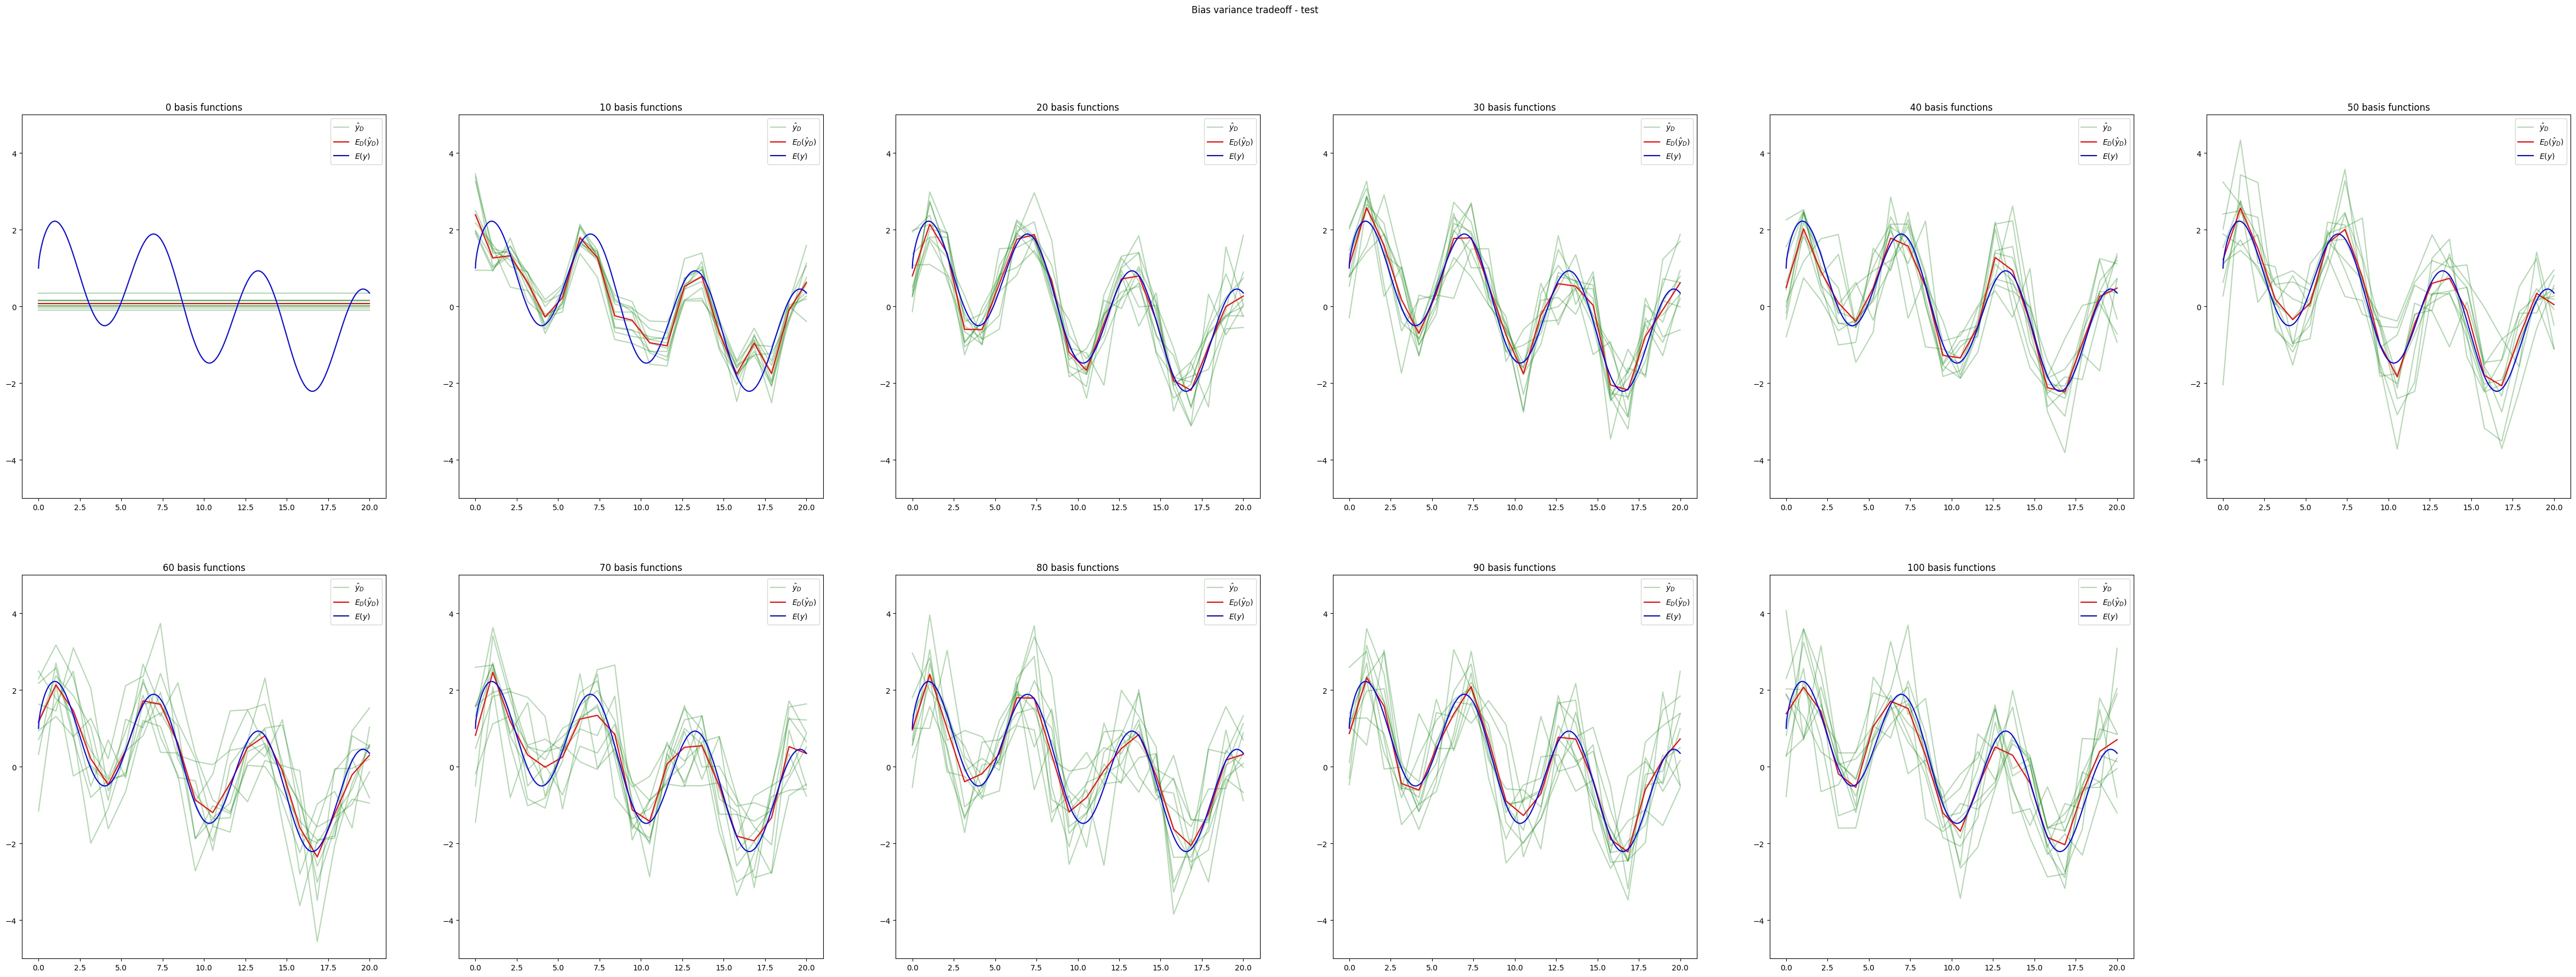

In [10]:
# bias variance tradeoff
# note, will use linspace for x_test to be able to graph the results

num_repetitions = 10

# range for plotting predictions on test values
x_test = np.linspace(0, 20, T)

# number of basis functions

fig, ax = plt.subplots(2, 6, figsize=(60, 20))
ax = ax.flatten()

for i, n in enumerate(num_bases):
  predictions = np.zeros((T, num_repetitions))

  for j in range(num_repetitions):
    x_train, y_train = generate_data(N)
    model = GaussianRegression(n)
    model.fit(x_train, y_train)
    yh = model.predict(x_test)
    predictions[:, j] = yh.flatten()
    ax[i].plot(x_test, yh, alpha=0.3, color='green', label='$\hat{y}_D$' if j == 0 else '')

  ax[i].set_title(f'{n} basis functions')
  mean_predictions = np.mean(predictions, axis=1)
  ax[i].plot(x_test, mean_predictions, color='red', label='$E_D(\hat{y}_D)$')
  ax[i].plot(x_range, f(x_range), label='$E(y)$', color='blue')
  ax[i].set_ylim(-5, 5)
  ax[i].legend()

fig.suptitle('Bias variance tradeoff - test')
ax[11].set_visible(False)

### 3. Plotting train and test error

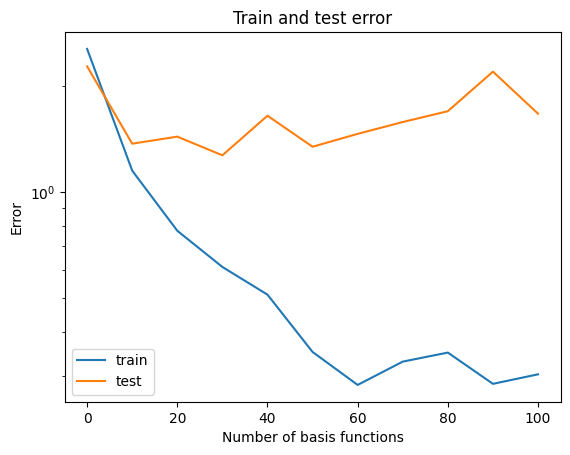

In [11]:
train_errors = np.zeros((num_repetitions, len(num_bases)))
test_errors = np.zeros((num_repetitions, len(num_bases)))

for i, n in enumerate(num_bases):
  for j in range(num_repetitions):
    x_train, y_train = generate_data(N)
    x_test, y_test = generate_data(T)
    model = GaussianRegression(n)
    model.fit(x_train, y_train)

    train_errors[j, i] = model.mse(x_train, y_train)
    test_errors[j, i] = model.mse(x_test, y_test)

mean_train_errors = np.mean(train_errors, axis=0)
mean_test_errors = np.mean(test_errors, axis=0)

plt.plot(num_bases, mean_train_errors, label='train')
plt.plot(num_bases, mean_test_errors, label='test')
plt.legend()
plt.title('Train and test error')
plt.xlabel('Number of basis functions')
plt.ylabel('Error')
plt.yscale('log')


### 4. Explaining bias and variance

Based on the test plot: The green lines get farther apart from each other (high inter-model variance) as well as erratic (high intra-model variance). The red line initially is close to the ground truth and gets better up to 30 basis functions. After that, it gets very far from the ground truth, contrary to expectations.

Based on the train plot: The green lines get farther apart from each other (high inter-model variance) as well as erratic (high intra-model variance). The red line initially is close to the ground truth and gets better with increasing basis functions (better bias).

Note: I changed to linspace to have nicer looking graphs, be consistent and make interpretation easier. Now the predictions are not as erratic. Average error in the test set still increases slightly but it is not as bad. These results follow expectations.

## Task 3: Regularization with cross-validation

### 1. Adding regularization

In [12]:
# Implementation of the gaussian regression model with lasso and ridge
class GaussianRegression:
  def __init__(self, D, add_bias=True, epsilon=5e-2, alpha=1e-3, lambdaa=1e-2, max_iter=1e5, lasso=False, ridge=False):
    self.add_bias = add_bias
    self.b = D                                        # b is the number of gaussian bases used
    self.epsilon = epsilon
    self.alpha = alpha
    self.lambdaa = lambdaa
    self.max_iter = max_iter
    self.w = None
    self.lasso = lasso
    self.ridge = ridge

  # This method creates the design matrix X
  def gaussian_bases(self, x):
    X = np.zeros((len(x), self.b))
    mus = np.linspace(0, 20, self.b)
    for i, mu in enumerate(mus):
      X[:, i] = gaussian(x, mu)
    return X

  def fit(self, x, y):
    X = self.gaussian_bases(x)                     # Generate the design matrix

    if y.ndim == 1:
      y = y.reshape(-1, 1)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))

    if self.lasso:
      self.w = self.lasso_fit(X, y)
      return self

    elif self.ridge:
      I = np.eye(X.shape[1])
      self.w = np.linalg.pinv(X.T @ X + self.lambdaa * I) @ X.T @ y
      return self

    else:
      self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
      return self

  def lasso_fit(self, X, y):
    w = np.zeros((X.shape[1], 1))
    e = np.inf
    i = 0
    while e > self.epsilon and i < self.max_iter:
      N, D = X.shape
      gradient = 1/N * X.T @ (X @ w - y) + self.lambdaa * np.sign(w)
      w = w - self.alpha * gradient
      e = np.linalg.norm(gradient)
      i += 1
    return w

  def predict(self, x):
    X = self.gaussian_bases(x)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ self.w

  def sse(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.sum((y - self.predict(x))**2)                       # Return the sum of squared error

  def mse(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.mean((y - self.predict(x))**2)

### 2. Cross-validation

In [13]:
lambdaas = np.logspace(-4, 2, 15)
N = 20
D = 70
num_datasets = 50

train_losses = np.zeros((num_datasets, len(lambdaas), 10))
test_losses = np.zeros((num_datasets, len(lambdaas), 10))
predictions = np.zeros((N, num_datasets, len(lambdaas), 10))

# iterate over many datasets
for i in range(num_datasets):
  x_train = np.linspace(0, 20, N)
  np.random.shuffle(x_train)
  epsilon = np.random.normal(0, 1, N)
  y_train = f(x_train) + epsilon

  # iterate over different values of lambda
  for j, k in enumerate(lambdaas):

    # iterate over different folds
    for l in range(10):
      lower_bound = int(l * N/10)
      upper_bound = int((l+1) * N/10)
      test_fold_x = x_train[lower_bound: upper_bound]
      test_fold_y = y_train[lower_bound: upper_bound]
      train_fold_x = np.concatenate((x_train[: lower_bound], x_train[upper_bound:]))
      train_fold_y = np.concatenate((y_train[: lower_bound], y_train[upper_bound:]))

      # train model
      model = GaussianRegression(D, lambdaa=k, ridge=True)
      model.fit(train_fold_x, train_fold_y)

      # record mse on train and test folds
      train_loss = model.mse(train_fold_x, train_fold_y)
      test_loss = model.mse(test_fold_x, test_fold_y)
      train_losses[i, j, l] = train_loss
      test_losses[i, j, l] = test_loss

      # record predictions
      predictions[:, i, j, l] = model.predict(np.sort(x_train)).flatten()




Text(0.5, 0.98, 'Ridge regression')

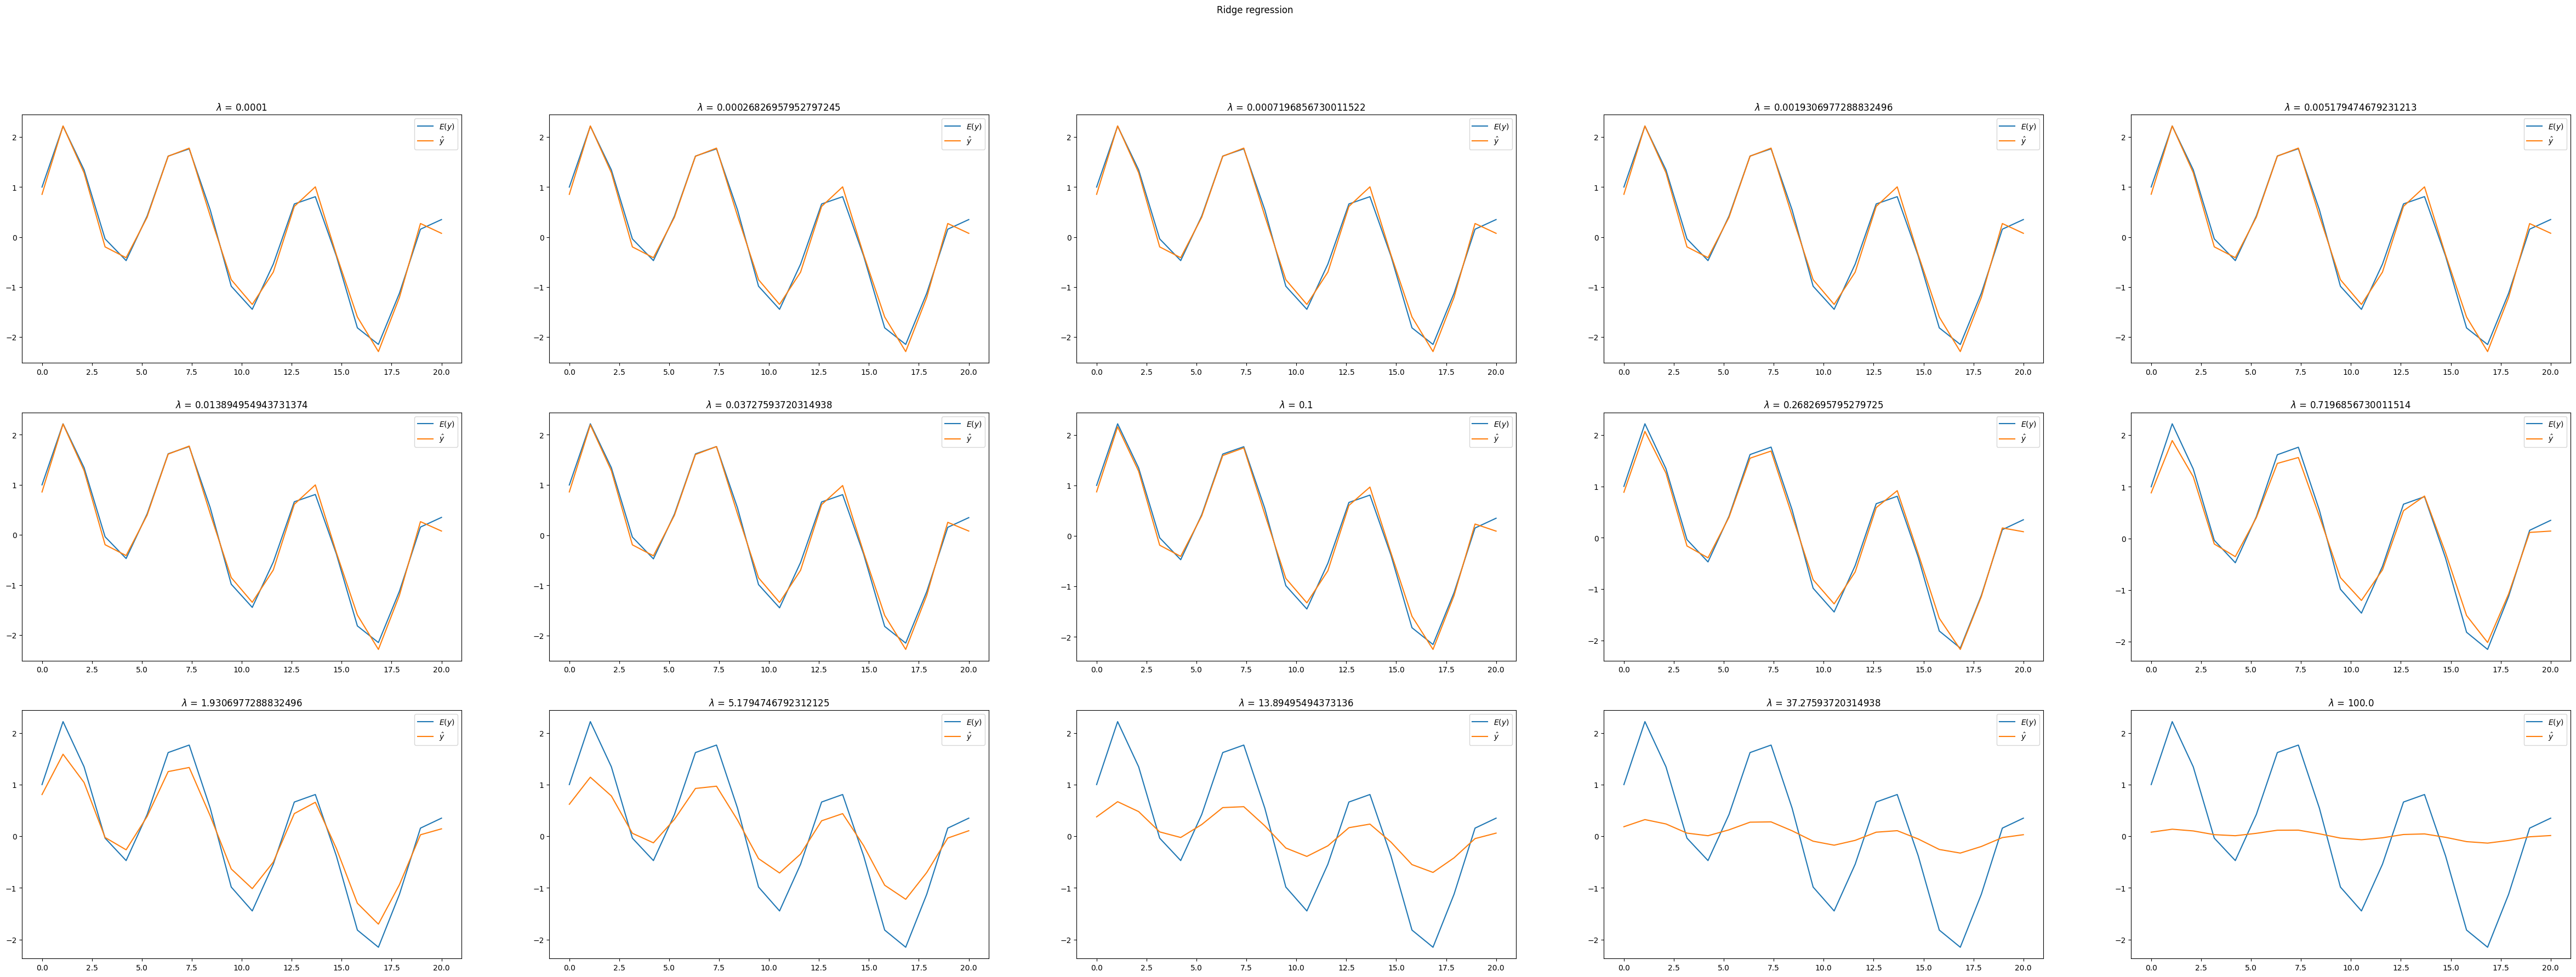

In [14]:
# plot predictions as a function of lambda
predictions = np.mean(predictions, axis=(1, 3))

fig, ax = plt.subplots(3, 5, figsize=(60, 20))
ax = ax.flatten()
x_train = np.linspace(0, 20, N)

for i in range(15):
  ax[i].plot(x_train, f(x_train), label='$E(y)$')
  ax[i].plot(x_train, predictions[:, i], label='$\hat{y}$')
  ax[i].set_title(f'$\lambda$ = {lambdaas[i]}')
  ax[i].legend()
fig.suptitle('Ridge regression')

### 3. Plotting train and test errors

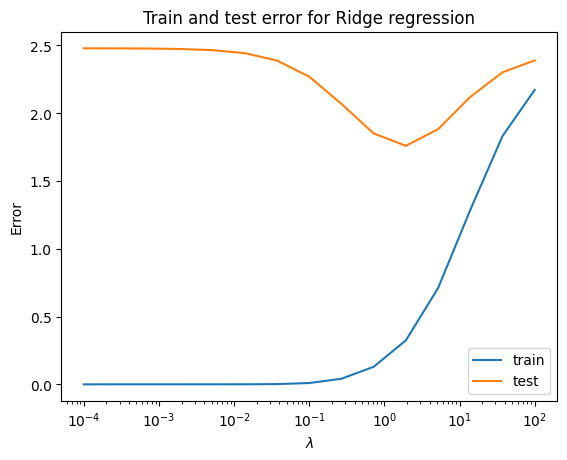

In [15]:
# plot train and test erroras a function of lambda
train_errors = np.mean(train_losses, axis=(0, 2))
test_errors = np.mean(test_losses, axis=(0, 2))

plt.plot(lambdaas, train_errors, label='train')
plt.plot(lambdaas, test_errors, label='test')
plt.legend()
plt.title('Train and test error for Ridge regression')
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.xscale('log')

In [16]:
train_losses = np.zeros((num_datasets, len(lambdaas), 10))
test_losses = np.zeros((num_datasets, len(lambdaas), 10))

# iterate over many datasets
for i in range(num_datasets):
  x_train = np.linspace(0, 20, N)
  np.random.shuffle(x_train)
  epsilon = np.random.normal(0, 1, N)
  y_train = f(x_train) + epsilon

  # iterate over different values of lambda
  for j, k in enumerate(lambdaas):

    # iterate over different folds
    for l in range(10):
      lower_bound = int(l * N/10)
      upper_bound = int((l+1) * N/10)
      test_fold_x = x_train[lower_bound: upper_bound]
      test_fold_y = y_train[lower_bound: upper_bound]
      train_fold_x = np.concatenate((x_train[: lower_bound], x_train[upper_bound:]))
      train_fold_y = np.concatenate((y_train[: lower_bound], y_train[upper_bound:]))

      # train model
      model = GaussianRegression(D, lambdaa=k, lasso=True, max_iter=1e3)
      model.fit(train_fold_x, train_fold_y)

      # record mse on train and test folds
      train_loss = model.mse(train_fold_x, train_fold_y)
      test_loss = model.mse(test_fold_x, test_fold_y)
      train_losses[i, j, l] = train_loss
      test_losses[i, j, l] = test_loss
  print(f'{i + 1} ', end='')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

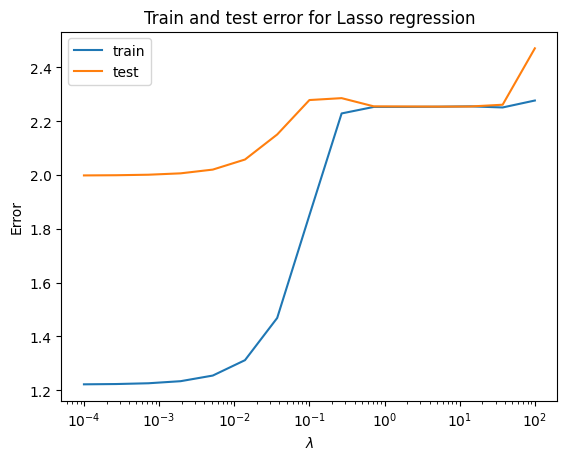

In [17]:
# plot train and test erroras a function of lambda
train_errors = np.mean(train_losses, axis=(0, 2))
test_errors = np.mean(test_losses, axis=(0, 2))

plt.plot(lambdaas, train_errors, label='train')
plt.plot(lambdaas, test_errors, label='test')
plt.legend()
plt.title('Train and test error for Lasso regression')
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.xscale('log')

### 4. Plotting bias-variance decomposition

In [18]:
# For Ridge


N = 100
D = 70
num_datasets = 50
lambdaas = np.logspace(-4, 2, 15)

# Note using linspace to average over datasets. Is there another way to do this?
x_train = np.linspace(0, 20, N)
x_test = np.linspace(0, 20, T)

# keep track of predictions and mse
predictions = np.zeros((T, num_datasets, len(lambdaas)))
mse = np.zeros((num_datasets, len(lambdaas)))

# iterate over datasets and lambda values in one loop
for d in range(num_datasets):
    # generate training and test samples with noise
    y_train = f(x_train) + np.random.normal(0, 1, N)
    y_test = f(x_test) + np.random.normal(0, 1, T)

    for n, lambdaa in enumerate(lambdaas):
        # train the model and predict on the test set ?????????????????
        model = GaussianRegression(D, lambdaa=lambdaa, ridge=True)
        model.fit(x_train, y_train)
        predictions[:, d, n] = model.predict(x_test).flatten()

        # calculate mse on the test set
        mse[d, n] = model.mse(x_test, y_test)

# calculate average predictions across datasets
average_predictions = np.mean(predictions, axis=1)

# calculate bias, variance, and error for each lambda
bias_squared = np.mean((average_predictions - f(x_test).reshape(-1, 1)) ** 2, axis=0)
variance = np.mean(np.var(predictions, axis=1), axis=0)
error = np.mean(mse, axis=0)

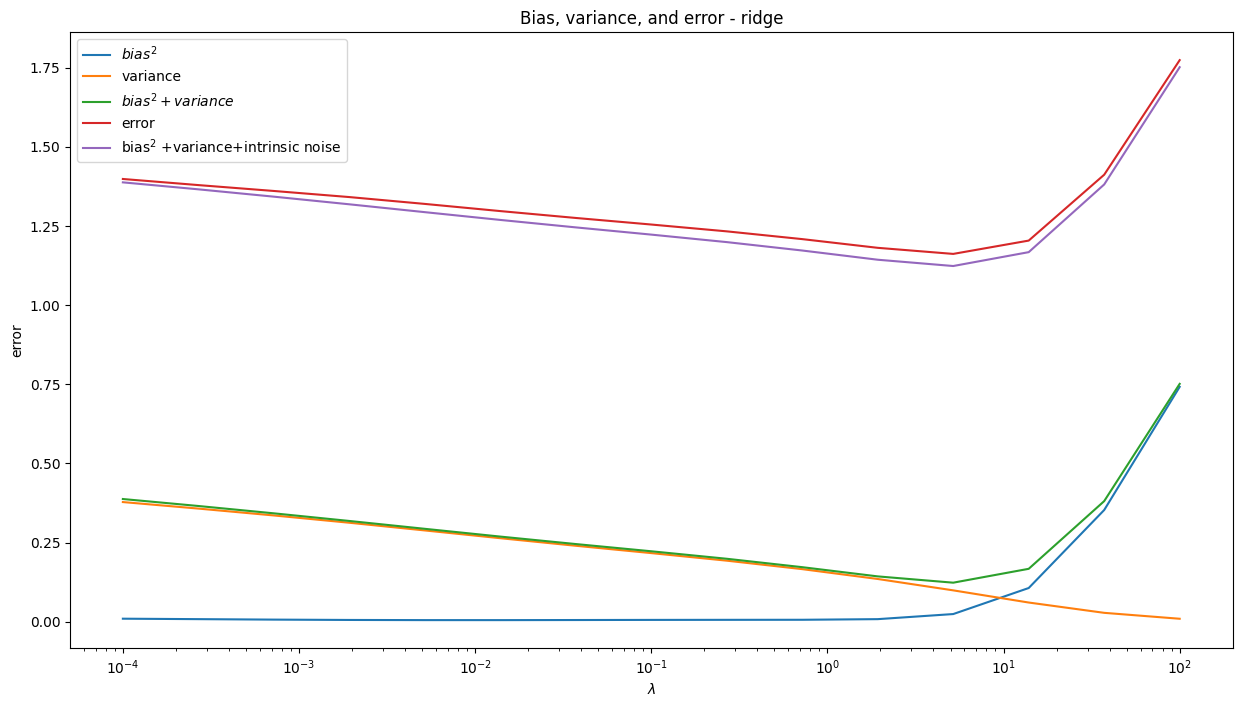

In [19]:
# plot bias and variance and error

plt.figure(figsize=(15, 8))

#bias
plt.plot(lambdaas, bias_squared, label='$bias^2$')

#variance
plt.plot(lambdaas, variance, label='variance')

# bias + variance
plt.plot(lambdaas, bias_squared + variance, label='$bias^2+variance$')

#error
plt.plot(lambdaas, error, label='error')

# bias + vaiance + intrinsic noise
plt.plot(lambdaas, bias_squared + variance + np.ones(len(lambdaas)), label='bias$^2$ +variance+intrinsic noise')

plt.title('Bias, variance, and error - ridge')
plt.xlabel('$\lambda$')
plt.ylabel('error')
plt.xscale('log')
plt.legend()

In [ ]:
# Lasso


N = 100
D = 70
num_datasets = 50
lambdaas = np.logspace(-4, 2, 15)

# Note using linspace to average over datasets. Is there another way to do this?
x_train = np.linspace(0, 20, N)
x_test = np.linspace(0, 20, T)

# keep track of predictions and mse
predictions = np.zeros((T, num_datasets, len(lambdaas)))
mse = np.zeros((num_datasets, len(lambdaas)))

# iterate over datasets and lambda values in one loop
for d in range(num_datasets):
    # generate training and test samples with noise
    y_train = f(x_train) + np.random.normal(0, 1, N)
    y_test = f(x_test) + np.random.normal(0, 1, T)

    for n, lambdaa in enumerate(lambdaas):
        # train the model and predict on the test set ?????????????????
        model = GaussianRegression(D, lambdaa=lambdaa, lasso=True)
        model.fit(x_train, y_train)
        predictions[:, d, n] = model.predict(x_test).flatten()

        # calculate mse on the test set
        mse[d, n] = model.mse(x_test, y_test)

# calculate average predictions across datasets
average_predictions = np.mean(predictions, axis=1)

# calculate bias, variance, and error for each lambda
bias_squared = np.mean((average_predictions - f(x_test).reshape(-1, 1)) ** 2, axis=0)
variance = np.mean(np.var(predictions, axis=1), axis=0)
error = np.mean(mse, axis=0)

In [ ]:
# plot bias and variance and error

plt.figure(figsize=(15, 8))

#bias
plt.plot(lambdaas, bias_squared, label='$bias^2$')

#variance
plt.plot(lambdaas, variance, label='variance')

# bias + variance
plt.plot(lambdaas, bias_squared + variance, label='$bias^2+variance$')

#error
plt.plot(lambdaas, error, label='error')

# bias + vaiance + intrinsic noise
plt.plot(lambdaas, bias_squared + variance + np.ones(len(lambdaas)), label='bias$^2$ +variance+intrinsic noise', linestyle='--')

plt.title('Bias, variance, and error - lasso')
plt.xlabel('$\lambda$')
plt.ylabel('error')
plt.xscale('log')
plt.legend()

### 5. Selecting the optimal lambda

For Ridge regression, the optimal lambda is very clearly around 1.1 as this value gives the minimum loss on the validation set. It is not a huge improvement over lambda = 0 i.e. no regularization. This might be because we are using linspace instead of random.uniform. For lasso, the best result is without regularization, this might be because we are using gradient descent truncated at 1000 iterations (to have a managable runtime) whic is iteself a form of regularization.

## Task 4: Effect of L2 and L1 regularization on loss

### 1. Generating synthetic data

In [ ]:
# Generate data
r = 0.8   # train/test ratio
train_size = int(n * r)
min_range = 0
max_range = 10
range_x = np.linspace(min_range, max_range, 100)
n = 50

x = np.random.uniform(min_range, max_range, n)
e = np.random.normal(0, 1, n)
y = f2(x) + e

# Plot the data
plt.plot(x, y, 'x')
plt.plot(range_x, f2(range_x))
plt.grid()

plt.title('Training data and original function')
plt.xlabel('x')
plt.ylabel('y')

### 2. Applying L1 and L2 regularization

In [ ]:
# Import necessary functions
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

class GradientDescent:

    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

class LinearRegression:
    def __init__(self, add_bias=True, l2_reg=0, l1_reg=0):
        self.add_bias = add_bias
        self.l2_reg = l2_reg
        self.l1_reg = l1_reg
        pass

    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):
            yh =  x @ w
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            grad += self.l2_reg* w + self.l1_reg*np.sign(w)
            return grad
        w0 = np.zeros(D)
        self.w = optimizer.run(gradient, x, y, w0)
        return self

    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(len(x))])
        yh = x@self.w
        return yh

In [ ]:
f2 = lambda x: -4 * x + 10
x = np.linspace(0, 10, 100)
y = f2(x) + np.random.normal(0, 1, len(x))

In [ ]:
# Lasso

cost = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.linalg.norm(w, ord=1)
reg_list = [0, 0.01, 0.1, 1, 10, 100]
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(30, 5))
for i, reg_coef in enumerate(reg_list):
    optimizer = GradientDescent(learning_rate=.01, max_iters=500, record_history=True)
    model = LinearRegression(optimizer, l1_reg=reg_coef)
    print(x.shape, y.shape)
    model.fit(x,y, optimizer)
    current_cost = lambda w: cost(w, reg_coef)
    plot_contour(current_cost, [-20,20], [-5,5], 50, axes[i])
    w_hist = np.vstack(optimizer.w_history)# T x 2
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f' lambda = {reg_coef}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
fig.suptitle('Lasso')
plt.show()


In [ ]:
# Ridge

cost = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.dot(w,w)/2
reg_list = [0, 0.01, 0.1, 1, 10, 100]
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(30, 5))
for i, reg_coef in enumerate(reg_list):
    optimizer = GradientDescent(learning_rate=.01, max_iters=500, record_history=True)
    model = LinearRegression(optimizer, l2_reg=reg_coef)
    model.fit(x,y, optimizer)
    current_cost = lambda w: cost(w, reg_coef)
    plot_contour(current_cost, [-20,20], [-5,5], 50, axes[i])
    w_hist = np.vstack(optimizer.w_history)# T x 2
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f' lambda = {reg_coef}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
fig.suptitle('Ridge')
plt.show()

### 5. Analyzing the effects of  L1 and L2 regularization

The contour plots allow us to observe that the minimum (center of contour plot) is moving closer to (0, 0) as lambda increases. It moves faster to (0, 0) with lasso than ridge regression, as expected since lasso regression is known to promote sparsity. Based on the contour plots, it also seems that the loss function is getting steeper and the effect is more pronounced with lasso. With a seeper loss function, we should expect gradient descent to converge faster as the norm of the gradient will be steeper. This is indeed what happens but another factor is that we initialize the weights at zero, therefore the distance to the minimum decreases as lambda increases. Creativity work might involve vizualizing this with the weights initialized randomly. 